In [1]:
from obspy.core import Stream, read, UTCDateTime
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import Normalize
import pandas as pd
import os 
import os.path

In [2]:
path = '/Users/sydneydybing/StrainProject/2024/taiwan_strain_data/'

stas = pd.read_csv(path + 'station_data.csv')
events = pd.read_csv(path + 'events_csv.csv')

In [3]:
events

,evt_id,origin_time,lat,lon,depth
0,2009-10-03_M6.1,2009-10-03T17:36:06.120,23.630,121.452,28.0
1,2013-10-31_M6.3,2013-10-31T12:02:08.720,23.590,121.437,10.0
2,2018-02-04_M6.1,2018-02-04T13:56:41.950,24.157,121.708,12.0


In [4]:
# # Calculate hypocentral distances and add to dataframe - only need to run once

# for idx in range(len(events)):
        
#     evt_id = events['evt_id'][idx]
#     print(evt_id)

#     eq_lon = events['lon'][idx]
#     eq_lat = events['lat'][idx]
    
#     hypdists = []
    
#     for i in range(len(stas)):

#         sta = stas['Sta'][i]
#         # print(sta)

#         sta_lat = float(stas['Lat'][i])
#         sta_lon = float(stas['Lon'][i])

#         distaz = gps2dist_azimuth(eq_lat, eq_lon, sta_lat, sta_lon)
#         dist_m = distaz[0]
#         dist_km = dist_m/1000

#         # print(dist_km)

#         hypdists.append(dist_km)
    
#     if evt_id == '2009-10-03_M6.1':
#         stas['2009_hyp_dist_km'] = hypdists
#     elif evt_id == '2013-10-31_M6.3':
#         stas['2013_hyp_dist_km'] = hypdists
#     elif evt_id == '2018-02-04_M6.1':
#         stas['2018_hyp_dist_km'] = hypdists

# stas.to_csv(path + 'station_data_hypdists.csv', index = False)

In [5]:
dist_array = pd.read_csv(path + 'station_data_hypdists.csv')
dist_array

,Sta,Lat,Lon,Depth(m),2009_hyp_dist_km,2013_hyp_dist_km,2018_hyp_dist_km
0,BCWB,24.2184,121.6891,-192,69.496535,74.182696,7.066640
1,TRKB,24.1614,121.6127,-192,61.088805,65.767547,9.697232
2,NTTB,24.1728,121.5259,-175,60.587926,65.180780,18.587874
3,SJNB,24.1073,121.6006,-193,54.988063,59.668808,12.226300
4,HGSB,23.4903,121.4237,-266,15.739505,11.125139,79.319331
5,CHMB,23.4868,121.4703,-191,15.969342,11.924641,78.079695
6,SSNB,23.4423,121.3981,-185,21.504342,16.833483,85.224271
7,ZANB,23.3947,121.4585,-218,26.068219,21.740867,88.175343
8,FBRB,23.1406,121.2796,-200,56.994188,52.307853,120.756809
9,SSTB,23.1340,121.3782,-199,55.447392,50.858196,118.191393


2009-10-03_M6.1


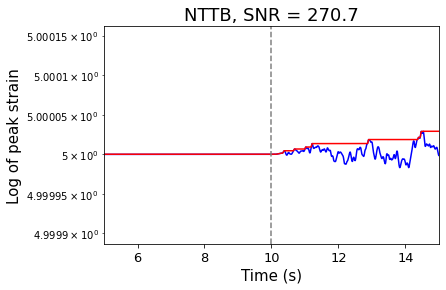

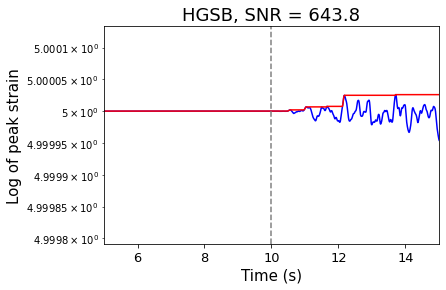

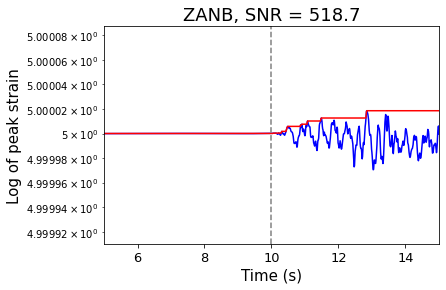

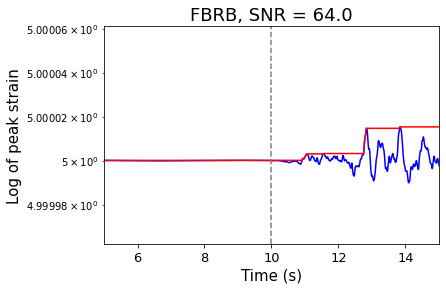

2013-10-31_M6.3


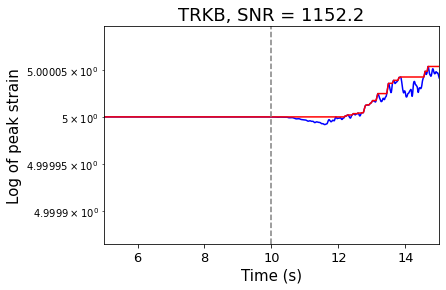

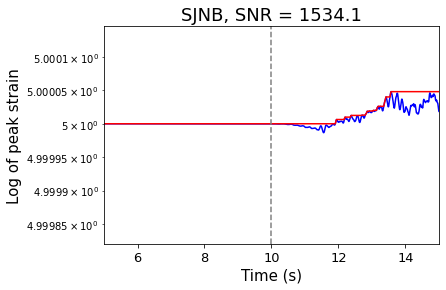

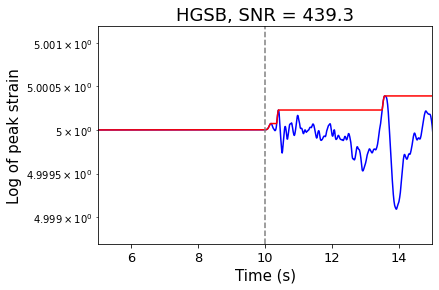

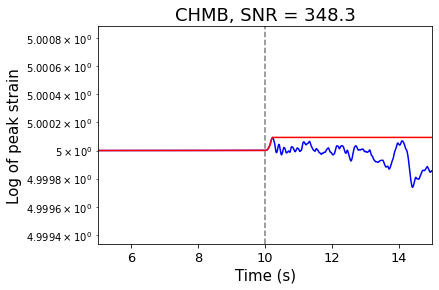

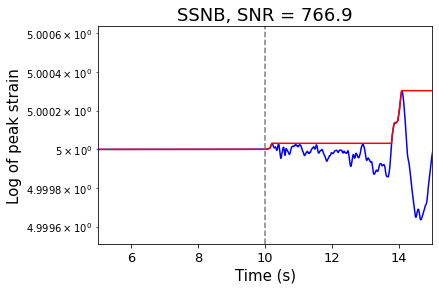

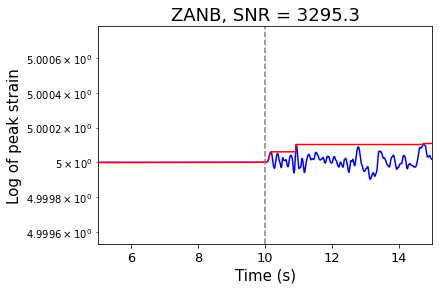

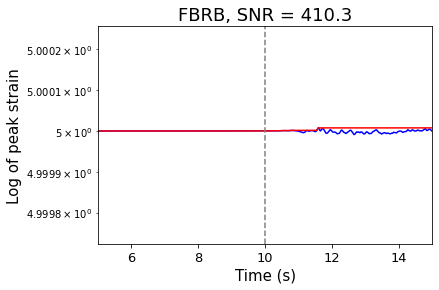

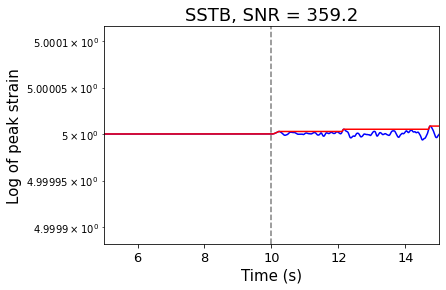

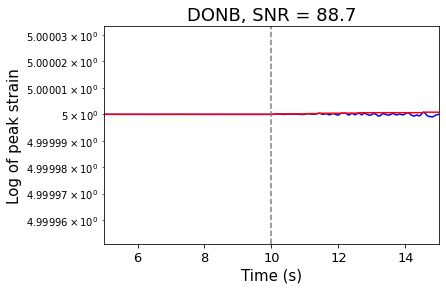

2018-02-04_M6.1


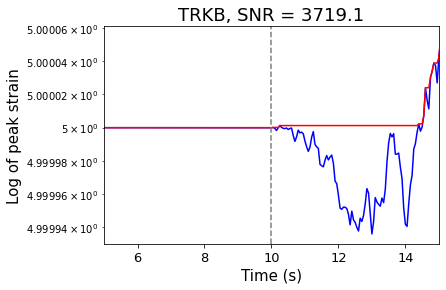

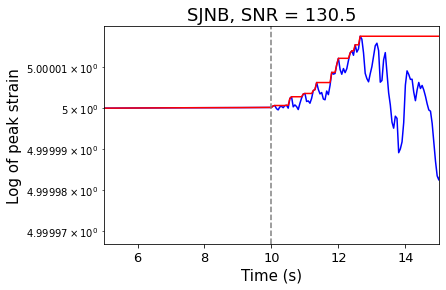

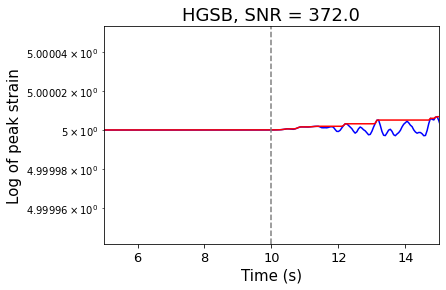

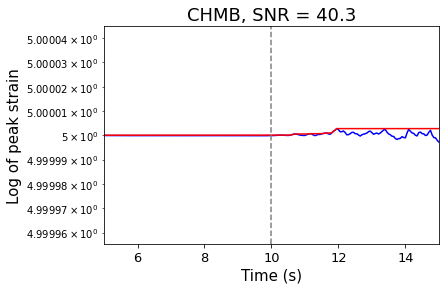

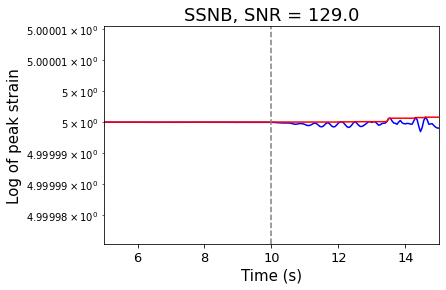

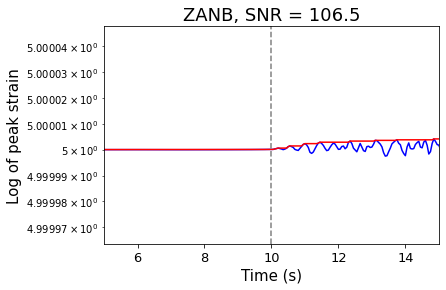

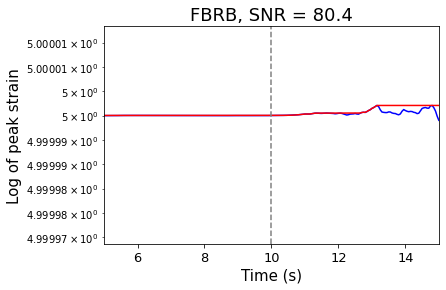

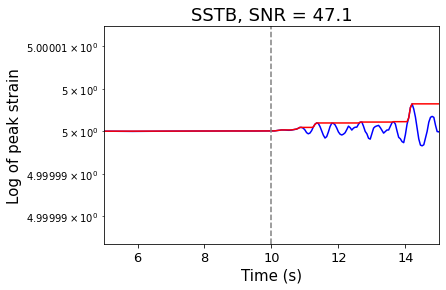

In [8]:
snrs_2009 = []
snrs_2013 = []
snrs_2018 = []

for i in range(len(events)):
    
    evt_id = events['evt_id'][i]
    print(evt_id)
    # origin_time = UTCDateTime(events['origin_time'][i])
    # print(origin_time)

    for idx in range(len(dist_array)):

        sta = dist_array['Sta'][idx]
        # print(sta)
        # plt.figure(figsize = (10,6), dpi = 300, facecolor = 'white', num = 1, clear = True)

        # Strain data
        try:
            pst = read(path + 'filtered_peak_uncal/' + evt_id + '/' + str(sta) + '.mseed')
            ev = read(path + 'filtered_trimmed_uncal/' + evt_id + '/' + sta + '.mseed')
        except:
            snr = '-'
            if evt_id == '2009-10-03_M6.1':
                snrs_2009.append(snr)
            elif evt_id == '2013-10-31_M6.3':
                snrs_2013.append(snr)
            elif evt_id == '2018-02-04_M6.1':
                snrs_2018.append(snr)
            continue
    
        times = ev[0].times()
        samples = np.arange(ev[0].stats.npts)
        data = ev[0].data

        samp_rate = ev[0].stats.sampling_rate

        samples_to_p_pick = 10 * samp_rate

        noise_start = int(samples_to_p_pick - 9*samp_rate) # 8 seconds of noise
        noise_end = int(samples_to_p_pick - 1*samp_rate)

        signal_start = int(samples_to_p_pick)
        signal_end = int(samples_to_p_pick + 10*samp_rate) # 30 seconds of signal

        signal = data[signal_start:signal_end]
        noise = data[noise_start:noise_end]

        noise_rms = np.sqrt(np.mean(noise**2))
        signal_rms = np.sqrt(np.mean(signal**2))
        snr = signal_rms/noise_rms
    #     snr_db = 20*np.log10(snr)
    
        if evt_id == '2009-10-03_M6.1':
            snrs_2009.append(snr)
        elif evt_id == '2013-10-31_M6.3':
            snrs_2013.append(snr)
        elif evt_id == '2018-02-04_M6.1':
            snrs_2018.append(snr)

        # Plot both waveforms

        plt.title(sta + ', SNR = ' + str(round(snr,1)), fontsize = 18)
        plt.plot(ev[0].times(), ev[0].data+5, color = 'blue')
        plt.plot(pst[0].times(), pst[0].data+5, color = 'red')
        plt.semilogy()
        plt.ylabel('Log of peak strain', fontsize = 15)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.xlim(5,15)
        # plt.ylim(min(pst_data[int(5*20):int(60*20)]), max(pst_data[int(5*20):int(60*20)])*1.1)
        plt.axvline(10, color = 'gray', linestyle = '--')
        plt.tick_params(labelsize = 13)
        plt.show()
    
#         # Create folder for the event
#         eq_sta_save_dir = path_to_files + 'figures/filtered_rms_peak_seismic_overlay_plots/' + str(eq_id) + '/'
#     #     print(eq_sta_save_dir)
#         if os.path.isdir(eq_sta_save_dir):
#             pass
#         else:
#             os.makedirs(eq_sta_save_dir)

#         plt.savefig(eq_sta_save_dir + str(sta) + '.png', format = 'PNG')
#         plt.close();
    
dist_array['snrs_2009'] = snrs_2009
dist_array['snrs_2013'] = snrs_2013
dist_array['snrs_2018'] = snrs_2018

dist_array.to_csv(path + 'station_data_hypdists_snrs_uncaldata.csv', index = False)

In [9]:
snr_array = pd.read_csv(path + 'station_data_hypdists_snrs_uncaldata.csv')
snr_array

,Sta,Lat,Lon,Depth(m),2009_hyp_dist_km,2013_hyp_dist_km,2018_hyp_dist_km,snrs_2009,snrs_2013,snrs_2018
0,BCWB,24.2184,121.6891,-192,69.496535,74.182696,7.066640,-,-,-
1,TRKB,24.1614,121.6127,-192,61.088805,65.767547,9.697232,-,1152.21068792,3719.11498193
2,NTTB,24.1728,121.5259,-175,60.587926,65.180780,18.587874,270.716246698,-,-
3,SJNB,24.1073,121.6006,-193,54.988063,59.668808,12.226300,-,1534.07980394,130.500720293
4,HGSB,23.4903,121.4237,-266,15.739505,11.125139,79.319331,643.761404319,439.289700698,372.02315898
5,CHMB,23.4868,121.4703,-191,15.969342,11.924641,78.079695,-,348.253432719,40.3375273883
6,SSNB,23.4423,121.3981,-185,21.504342,16.833483,85.224271,-,766.890944463,129.022087472
7,ZANB,23.3947,121.4585,-218,26.068219,21.740867,88.175343,518.690744579,3295.29308104,106.461483121
8,FBRB,23.1406,121.2796,-200,56.994188,52.307853,120.756809,63.9759287277,410.302431106,80.3549037178
9,SSTB,23.1340,121.3782,-199,55.447392,50.858196,118.191393,-,359.179108909,47.0874813332
